# Measure Impact using Semantic Scholar

### Neil D. Lawrence 7th June 2021

This notebook looks at the actual impact of the papers published using the Semantic Scholar data base for tracking citations.

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [2]:
import cmtutils as cu
import cmtutils.nipsy as nipsy
import cmtutils.plot as plot

In [3]:
import pandas as pd
import numpy as np

In [4]:
papers = cu.Papers()

Loaded Papers.
Loaded Paper Subjects.


https://proceedings.neurips.cc/paper/2014 

In [5]:

UPDATE_IMPACTS = False # Set to True to download impacts from Semantic Scholar

The impact of the different papers is downloaded from Semantic scholar using their REST API. This can take some time, and they also throttle the calls. At the moment the code below deosn't handle the throttling correctly. However, you it will load the cached version of of citations scores from the given date.

In [6]:
if UPDATE_IMPACTS:
    from datetime import datetime
    date=datetime.today().strftime('%Y-%m-%d')
else:
    date = "2021-06-11"

In [7]:
# Rerun to download impacts from Semantic Scholar
if UPDATE_IMPACTS:
    semantic_ids = nipsy.load_semantic_ids()
    citations_dict = citations.to_dict(orient='index')
    # Need to be a bit cleverer here. Semantic scholar will throttle this call.
    sscholar = nipsy.download_citation_counts(citations_dict=citations_dict, semantic_ids=semantic_ids)
    citations = pd.DataFrame.from_dict(citations_dict, orient="index") 
    citations.to_pickle(date + '-semantic-scholar-info.pickle')
else: 
    citations = nipsy.load_citation_counts(date=date)



The final decision sheet provides information about what happened to all of the papers.

In [8]:
decisions = nipsy.load_decisions()
nipsy.augment_decisions(decisions)

This is joined with the citation information to provide our main ability to understand the impact of these papers.

In [9]:
joindf = nipsy.join_decisions_citations(decisions, citations)

## Correlation of Quality Scores and Citation

Our first study will be to check the correlation between quality scores of papers and how many times that the papers have been cited in practice. In the plot below, rejected papers are given as crosses, accepted papers are given as dots. We include all papers, whether published in a venue or just available through ArXiv or other preprint servers. We show the published/non-published quality scores and $\log_{10}(1+\text{citations})$ for all papers in the plot below. In the plot we are showing each point corrupted by some Laplacian noise and also removing axes. The idea is to give a sense of the distribution rather than reveal the score of a particular paper. 

In [10]:
import matplotlib.pyplot as plt
import mlai as ma

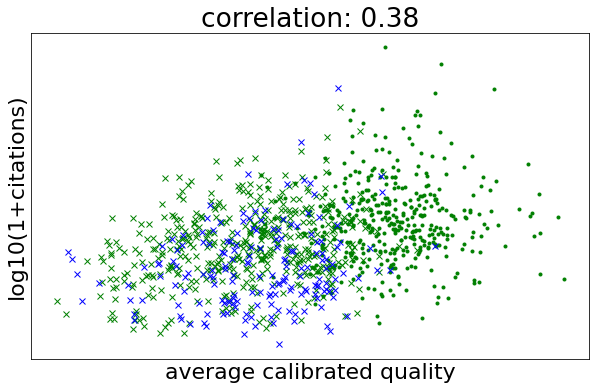

In [11]:
column = "average_calibrated_quality"
filter_col = "all"
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot.log_one_citations(column, joindf, filt=joindf[filter_col], ax=ax)
ax.set_xticks([])
ma.write_figure(filename="citations-vs-{col}-{filt}.svg".format(filt=filter_col, col=column.replace("_", "-")),
                   directory="./neurips")

The correlation seems strong, but of course, we are looking at papers which were accepted and rejected by the conference. This is dangerous, as it is quite likely that presentation at the conference may provide some form of lift to the papers' numbers of citations. So, the right thing to do is to look at the groups separately. 

Looking at the accepted papers only shows a very different picture. There is very little correlation between accepted papers' quality scores and the number of citations they receive. 

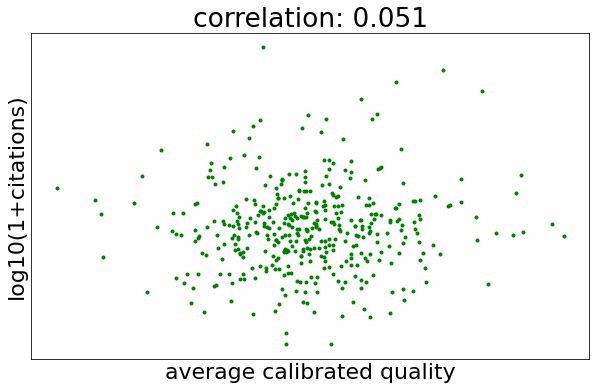

In [12]:
column = "average_calibrated_quality"
filter_col = "accept"
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot.log_one_citations(column, joindf, filt=joindf[filter_col], ax=ax)
ma.write_figure(filename="citations-vs-{col}-{filt}.svg".format(filt=filter_col, col=column.replace("_", "-")),
                   directory="./neurips")

Conversely, looking at rejected papers only, we do see a slight trend, with higher scoring papers achieving more citations on average. This, combined with the lower average number of citations in the rejected paper group, alongside their lower average scores, explains the correlation we originally observed.

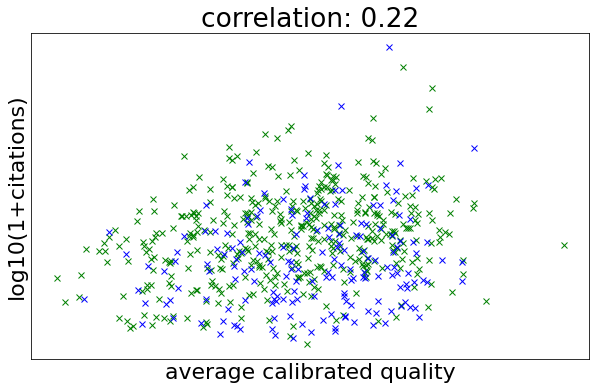

In [13]:
column = "average_calibrated_quality"
filter_col = "reject"
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot.log_one_citations(column, joindf, filt=joindf[filter_col], ax=ax)
ma.write_figure(filename="citations-vs-{col}-{filt}.svg".format(filt=filter_col, col=column.replace("_", "-")),
                   directory="./neurips")

Welling and Ghahramani introduced an "impact" score in NeurIPS 2013, we might expect the impact score to show correlation. And indeed, despite the lower range of the score (a reviewer can score either 1 or 2) we do see *some* correlation, although it is relatively weak.

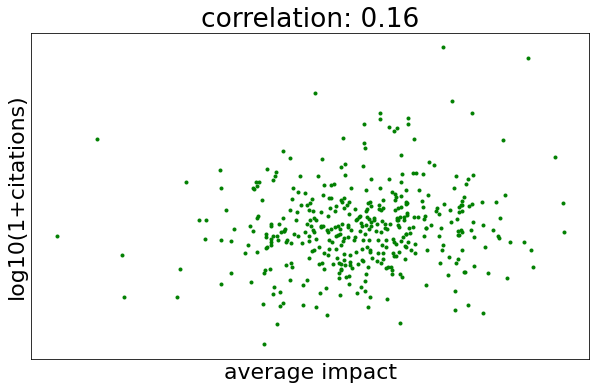

In [14]:
column = "average_impact"
filter_col = "accept"
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot.log_one_citations(column, joindf, filt=joindf[filter_col], ax=ax)
ma.write_figure(filename="citations-vs-{col}-{filt}.svg".format(filt=filter_col, col=column.replace("_", "-")),
                   directory="./neurips")

Finally, we also looked at correlation between the *confidence* score and the impact. Here correlation is somewhat stronger. Why should confidence be an indicator of higher citations? A plausible explanation is that there is confounder driving both variables. For example, it might be that papers which are easier to understand (due to elegance of the idea, or quality of exposition) inspire greater reviewer confidence and also increase the number of citations.

In [ ]:
column = 'average_confidence'
filter_col = "accept"
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot.log_one_citations(column, joindf, filt=joindf[filter_col], ax=ax)
ma.write_figure(filename="citations-vs-{col}-{filt}.svg".format(filt=filter_col, col=column.replace("_", "-")),
                   directory="./neurips")

## Bootstrap Code for Correlations

In [43]:
def bootstrap_index(df):
    n = len(df.index)
    return df.index[np.random.randint(n, size=n)]

In [53]:
for column in ["average_quality", "average_impact", "average_confidence"]:
    cor = []
    for i in range(1000):
        ind = bootstrap_index(joindf.loc[joindf.accept])
        cor.append(joindf.loc[ind][column].corr(np.log(1+joindf.loc[ind]['numCitedBy'])))
    cora = np.array(cor)
    rho = cora.mean()
    twosd = 2*np.sqrt(cora.var())
    print("{column}".format(column=column.replace("_", " ")))
    print("Mean correlation is {rho} +/- {twosd}".format(rho=rho, twosd=twosd))

average quality
Mean correlation is 0.021174458186652544 +/- 0.09359439862608683
average impact
Mean correlation is 0.15698793774407596 +/- 0.09232394023657897
average confidence
Mean correlation is 0.2501670915229445 +/- 0.0925231566891696
